# MODELO GENERICO PARA ENSAMBLAR

In [76]:
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # more advanced plotting
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.5}'.format)
pd.set_option('mode.chained_assignment', None) # Deshabilita SettingWithCopyWarning. Ojo.
from functools import reduce
import time

## Modificar esta celda:

In [77]:
###############################################################################################################
run_name = 'level3_con_CATBoost'+str(int(time.time()))
###############################################################################################################
models_directory = '../model_predictions/'
###############################################################################################################
output_directory = '../model_predictions_ensambles/'
###############################################################################################################
# si no defino path models usa todos los que encuentre en models_directory
# path_models = 
###############################################################################################################
# Acá elijo el modelo que quiero usar
params_cat = {
    'iterations': 5000,
    'depth':10, 
    'loss_function':'RMSE',
    'learning_rate' : 0.05}

early_stopping_rounds=100
from catboost import CatBoostRegressor
model_class=CatBoostRegressor
model=CatBoostRegressor(**params_cat)

###############################################################################################################
def procesar_dataframe(df):
    # podemos agregar columnas acá
    return df
###############################################################################################################

In [78]:
import os
from os.path import expanduser
def crear_si_no_existe(dl_path):
    if not os.path.exists(dl_path):
        print("path doesn't exist. trying to make")
        os.makedirs(dl_path)
    return
crear_si_no_existe(output_directory + run_name )

path doesn't exist. trying to make


In [79]:
y = np.log1p(pd.read_csv('../data/train.csv', index_col=['id'])['precio'])
y.sort_index(inplace=True)

In [80]:
import os
def get_model_names(models_directory):
    l=[]
    for x in os.walk(models_directory):
        if str(x[0]) == models_directory:
            continue
        if '.ipynb_checkpoints' in str(x[0]):
            continue
        run_name=str(x[0])[len(models_directory):]
        l.append(run_name)
    return l

In [81]:
def make_path(path_model, train_or_test):
    return models_directory + path_model + '/' + path_model + '_' + train_or_test + '.csv'

In [82]:
def read_csv_and_log_transform(path):
    df = pd.read_csv(path, header = None)
    df.columns = ['id', 'pred']
    df.set_index('id', inplace=True)
    df.sort_index(inplace=True)
    df['pred'] = np.log1p(df['pred'])
    return df

In [83]:
# si no especificamos con que modelos queremos correr el modelo usamos todos:
if not 'path_models' in vars():
    path_models = get_model_names(models_directory)

pred_models_train = []
pred_models_test = []
path_models_buenos = []
indices_models_validos = []
for i in range(len(path_models)):
    path_model=path_models[i]
    hayerror = False
    try:
        a=(read_csv_and_log_transform(make_path(path_model, 'train')).rename(columns={'pred':str(path_model)}))
    except:
        hayerror=True
    try:
        b=(read_csv_and_log_transform(make_path(path_model, 'test')).rename(columns={'pred':str(path_model)}))
    except:
        hayerror=True
    if not hayerror:
        indices_models_validos.append(i)
        pred_models_train.append(a)
        pred_models_test.append(b)
        path_models_buenos.append(path_model)

    else:
         print("error en ",path_model,"\n")
            
path_models=path_models_buenos

archivo_nombres_modelos = open(output_directory + run_name +"/" +run_name+"_modelos_utilizados.txt","w+" )
archivo_nombres_modelos.write("%s\n" % path_models)
archivo_nombres_modelos.close()

In [84]:
y = np.log1p(pd.read_csv('../data/train.csv', index_col=['id'])['precio'])
y.sort_index(inplace=True)
df_train_backup= reduce(lambda left,right: pd.concat([left, right], axis=1), pred_models_train)
df_test_backup=reduce(lambda left,right: pd.concat([left, right], axis=1), pred_models_test)

# Correlaciones en Test de los modelos que vamos a usar

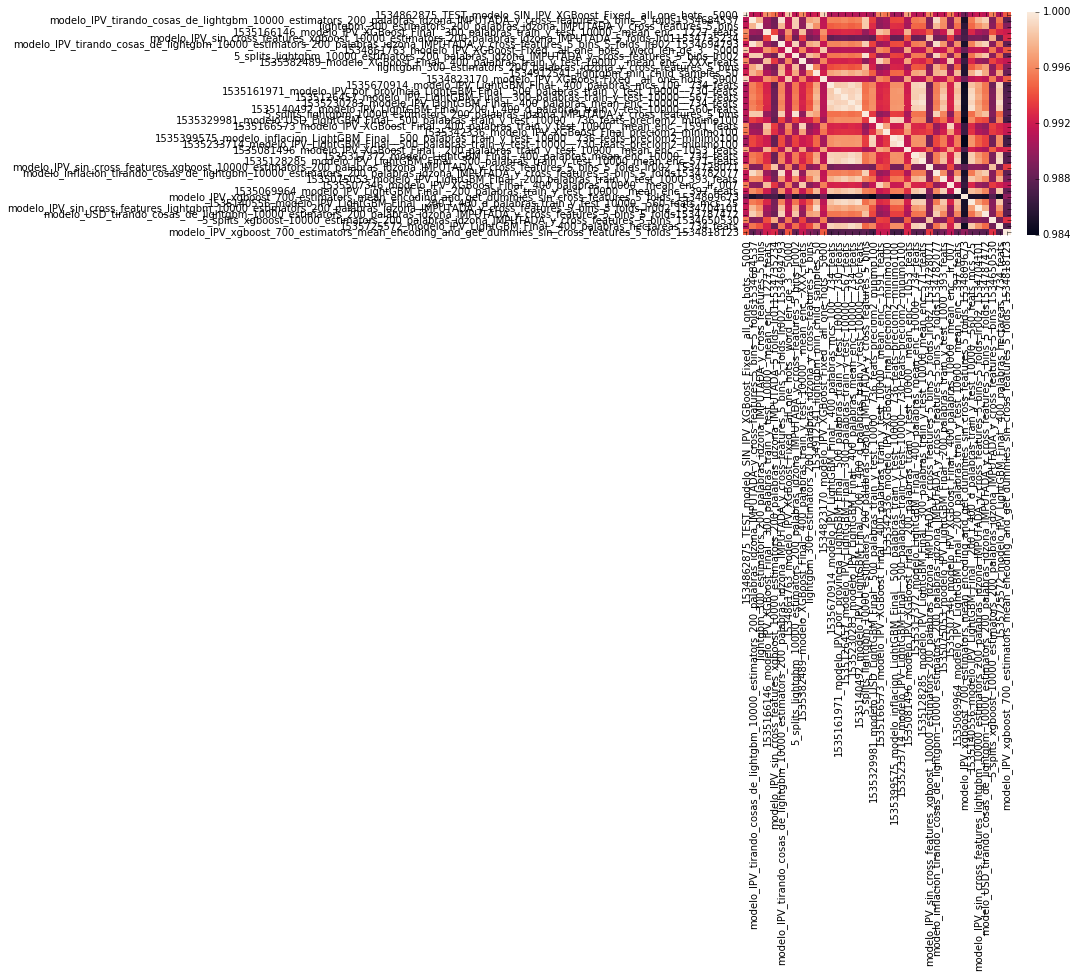

In [85]:
modelos = pd.concat(pred_models_test,axis=1)
#modelos.columns = range(len(modelos.columns))

corr_matrix=modelos.corr()

import seaborn as sns
%matplotlib inline

# load the R package ISLR
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

In [86]:
n_splits = 5
target = 'log1p_precio' # Solo anda este por ahora

In [87]:
df_backup = pd.concat([df_train_backup, df_test_backup], axis=0)
from sklearn import preprocessing
categorical_features = df_backup.select_dtypes(include = ["object", "category"]).columns
for categorical_feature in categorical_features:
    if categorical_feature in ['titulo', 'descripcion', 'direccion']:
        print('Salteando %s' %categorical_feature)
        continue
    print('Converting %s to categorical, label encoded.' %(categorical_feature))
    lb = preprocessing.LabelEncoder()
    lb.fit(df_backup[categorical_feature].astype('str'))
    df_backup[categorical_feature] = lb.transform(df_backup[categorical_feature].astype('str'))
df_train_backup = df_backup.loc[df_train_backup.index]
df_test_backup = df_backup.loc[df_test_backup.index]
del df_backup

In [88]:
df_train_backup = procesar_dataframe(df_train_backup)
df_test_backup = procesar_dataframe(df_test_backup)

df_train=df_train_backup
df_test=df_test_backup

print('df_train shape: ' + str(df_train.shape))
print('df_test shape: ' + str(df_test.shape))

df_train shape: (240000, 38)
df_test shape: (60000, 38)


# Entrenar k modelos

In [89]:
# FINAL con learning rate 0.05
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.base import clone

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
out_of_fold_predictions = pd.Series(np.zeros(df_train.shape[0]), index=df_train.index)
models = list()
col_prefix = run_name + '_val_rmse'
rmses_cols = {}
rmses_train_cols = {}
for i in range(n_splits):
    rmses_cols[col_prefix + '_fold' + str(i)] = np.array([0.0])
    rmses_train_cols[col_prefix + '_fold' + str(i)] = np.array([0.0])
rmses = pd.DataFrame(rmses_cols)
rmses_train = pd.DataFrame(rmses_train_cols)
idx_train = None
idx_val = None
for i, (int_idx_train, int_idx_val) in enumerate(kfold.split(df_train, y)):
    print('Training on fold: %d' %i)
    idx_train = df_train.iloc[int_idx_train].index
    idx_val = df_train.iloc[int_idx_val].index
    instance = clone(model)
    eval_set = [(df_train.loc[idx_val], y[idx_val])]
    instance.fit(df_train.loc[idx_train], y[idx_train], verbose=True, early_stopping_rounds = early_stopping_rounds, eval_set = eval_set)
    models.append(instance)
    y_pred = instance.predict(df_train.loc[idx_val])
    y_pred = pd.Series(y_pred, index=idx_val)
    out_of_fold_predictions[idx_val] = y_pred[idx_val]
    rmse = np.sqrt(np.mean((y_pred - y[idx_val]) ** 2))
    rmses[col_prefix + '_fold' + str(i)] = rmse
    rmse_train = 0.0
    #rmse_train = np.sqrt(np.mean((instance.predict(df_train.loc[idx_train]) - y[idx_train]) ** 2))
    rmses_train[col_prefix + '_fold' + str(i)] = rmse_train
    print('RMSE: %f' %rmse)
rmses = pd.concat([rmses, rmses_train], axis=0)
rmses

Training on fold: 0
0:	learn: 13.7130395	test: 13.7155663	best: 13.7155663 (0)	total: 151ms	remaining: 12m 36s
1:	learn: 13.0278696	test: 13.0303826	best: 13.0303826 (1)	total: 286ms	remaining: 11m 54s
2:	learn: 12.3769298	test: 12.3793496	best: 12.3793496 (2)	total: 462ms	remaining: 12m 50s
3:	learn: 11.7585018	test: 11.7608941	best: 11.7608941 (3)	total: 645ms	remaining: 13m 25s
4:	learn: 11.1710669	test: 11.1733897	best: 11.1733897 (4)	total: 784ms	remaining: 13m 2s
5:	learn: 10.6130295	test: 10.6152713	best: 10.6152713 (5)	total: 909ms	remaining: 12m 36s
6:	learn: 10.0828653	test: 10.0850129	best: 10.0850129 (6)	total: 1.05s	remaining: 12m 27s
7:	learn: 9.5792399	test: 9.5813129	best: 9.5813129 (7)	total: 1.18s	remaining: 12m 19s
8:	learn: 9.1007529	test: 9.1027463	best: 9.1027463 (8)	total: 1.32s	remaining: 12m 14s
9:	learn: 8.6462441	test: 8.6481600	best: 8.6481600 (9)	total: 1.47s	remaining: 12m 14s
10:	learn: 8.2144703	test: 8.2163258	best: 8.2163258 (10)	total: 1.64s	remaining

92:	learn: 0.2734635	test: 0.2776311	best: 0.2776311 (92)	total: 12.9s	remaining: 11m 19s
93:	learn: 0.2706984	test: 0.2749061	best: 0.2749061 (93)	total: 13s	remaining: 11m 18s
94:	learn: 0.2681945	test: 0.2724689	best: 0.2724689 (94)	total: 13.2s	remaining: 11m 19s
95:	learn: 0.2658994	test: 0.2702168	best: 0.2702168 (95)	total: 13.3s	remaining: 11m 18s
96:	learn: 0.2638085	test: 0.2681738	best: 0.2681738 (96)	total: 13.4s	remaining: 11m 19s
97:	learn: 0.2619016	test: 0.2663057	best: 0.2663057 (97)	total: 13.6s	remaining: 11m 18s
98:	learn: 0.2601635	test: 0.2645984	best: 0.2645984 (98)	total: 13.7s	remaining: 11m 19s
99:	learn: 0.2585823	test: 0.2630305	best: 0.2630305 (99)	total: 13.8s	remaining: 11m 18s
100:	learn: 0.2571416	test: 0.2616195	best: 0.2616195 (100)	total: 14s	remaining: 11m 18s
101:	learn: 0.2558262	test: 0.2603258	best: 0.2603258 (101)	total: 14.1s	remaining: 11m 18s
102:	learn: 0.2546374	test: 0.2591679	best: 0.2591679 (102)	total: 14.3s	remaining: 11m 19s
103:	lea

182:	learn: 0.2405619	test: 0.2466154	best: 0.2466154 (182)	total: 26.8s	remaining: 11m 45s
183:	learn: 0.2405079	test: 0.2466022	best: 0.2466022 (183)	total: 26.9s	remaining: 11m 45s
184:	learn: 0.2404599	test: 0.2465879	best: 0.2465879 (184)	total: 27.1s	remaining: 11m 46s
185:	learn: 0.2404118	test: 0.2465707	best: 0.2465707 (185)	total: 27.3s	remaining: 11m 47s
186:	learn: 0.2403787	test: 0.2465570	best: 0.2465570 (186)	total: 27.5s	remaining: 11m 47s
187:	learn: 0.2403075	test: 0.2465406	best: 0.2465406 (187)	total: 27.7s	remaining: 11m 48s
188:	learn: 0.2402583	test: 0.2465332	best: 0.2465332 (188)	total: 27.8s	remaining: 11m 48s
189:	learn: 0.2402257	test: 0.2465156	best: 0.2465156 (189)	total: 28s	remaining: 11m 48s
190:	learn: 0.2401950	test: 0.2465068	best: 0.2465068 (190)	total: 28.2s	remaining: 11m 49s
191:	learn: 0.2401678	test: 0.2465062	best: 0.2465062 (191)	total: 28.3s	remaining: 11m 48s
192:	learn: 0.2401484	test: 0.2464961	best: 0.2464961 (192)	total: 28.5s	remaining

272:	learn: 0.2374554	test: 0.2458429	best: 0.2458429 (272)	total: 40.8s	remaining: 11m 47s
273:	learn: 0.2374173	test: 0.2458539	best: 0.2458429 (272)	total: 41s	remaining: 11m 46s
274:	learn: 0.2373959	test: 0.2458473	best: 0.2458429 (272)	total: 41.1s	remaining: 11m 46s
275:	learn: 0.2373724	test: 0.2458417	best: 0.2458417 (275)	total: 41.2s	remaining: 11m 45s
276:	learn: 0.2373413	test: 0.2458385	best: 0.2458385 (276)	total: 41.4s	remaining: 11m 45s
277:	learn: 0.2373291	test: 0.2458392	best: 0.2458385 (276)	total: 41.5s	remaining: 11m 44s
278:	learn: 0.2373049	test: 0.2458380	best: 0.2458380 (278)	total: 41.7s	remaining: 11m 44s
279:	learn: 0.2372868	test: 0.2458331	best: 0.2458331 (279)	total: 41.8s	remaining: 11m 44s
280:	learn: 0.2372511	test: 0.2458269	best: 0.2458269 (280)	total: 42s	remaining: 11m 44s
281:	learn: 0.2372205	test: 0.2458144	best: 0.2458144 (281)	total: 42.1s	remaining: 11m 44s
282:	learn: 0.2371883	test: 0.2458137	best: 0.2458137 (282)	total: 42.2s	remaining: 

363:	learn: 0.2348879	test: 0.2454385	best: 0.2454385 (363)	total: 54.2s	remaining: 11m 30s
364:	learn: 0.2348724	test: 0.2454367	best: 0.2454367 (364)	total: 54.3s	remaining: 11m 29s
365:	learn: 0.2348518	test: 0.2454331	best: 0.2454331 (365)	total: 54.5s	remaining: 11m 29s
366:	learn: 0.2348230	test: 0.2454299	best: 0.2454299 (366)	total: 54.6s	remaining: 11m 29s
367:	learn: 0.2348054	test: 0.2454293	best: 0.2454293 (367)	total: 54.7s	remaining: 11m 28s
368:	learn: 0.2347630	test: 0.2454235	best: 0.2454235 (368)	total: 54.9s	remaining: 11m 28s
369:	learn: 0.2347337	test: 0.2454137	best: 0.2454137 (369)	total: 55s	remaining: 11m 28s
370:	learn: 0.2347042	test: 0.2454100	best: 0.2454100 (370)	total: 55.1s	remaining: 11m 27s
371:	learn: 0.2346868	test: 0.2454070	best: 0.2454070 (371)	total: 55.3s	remaining: 11m 27s
372:	learn: 0.2346529	test: 0.2453995	best: 0.2453995 (372)	total: 55.4s	remaining: 11m 26s
373:	learn: 0.2345999	test: 0.2453972	best: 0.2453972 (373)	total: 55.5s	remaining

453:	learn: 0.2326271	test: 0.2451179	best: 0.2451175 (452)	total: 1m 6s	remaining: 11m 9s
454:	learn: 0.2326073	test: 0.2451202	best: 0.2451175 (452)	total: 1m 7s	remaining: 11m 9s
455:	learn: 0.2325924	test: 0.2451209	best: 0.2451175 (452)	total: 1m 7s	remaining: 11m 9s
456:	learn: 0.2325724	test: 0.2451187	best: 0.2451175 (452)	total: 1m 7s	remaining: 11m 9s
457:	learn: 0.2325429	test: 0.2451200	best: 0.2451175 (452)	total: 1m 7s	remaining: 11m 8s
458:	learn: 0.2325203	test: 0.2451265	best: 0.2451175 (452)	total: 1m 7s	remaining: 11m 8s
459:	learn: 0.2324946	test: 0.2451280	best: 0.2451175 (452)	total: 1m 7s	remaining: 11m 8s
460:	learn: 0.2324606	test: 0.2451189	best: 0.2451175 (452)	total: 1m 7s	remaining: 11m 8s
461:	learn: 0.2324184	test: 0.2451177	best: 0.2451175 (452)	total: 1m 8s	remaining: 11m 8s
462:	learn: 0.2323865	test: 0.2451204	best: 0.2451175 (452)	total: 1m 8s	remaining: 11m 8s
463:	learn: 0.2323579	test: 0.2451099	best: 0.2451099 (463)	total: 1m 8s	remaining: 11m 8s

543:	learn: 0.2305541	test: 0.2450074	best: 0.2450074 (543)	total: 1m 19s	remaining: 10m 50s
544:	learn: 0.2305379	test: 0.2450043	best: 0.2450043 (544)	total: 1m 19s	remaining: 10m 50s
545:	learn: 0.2305248	test: 0.2449922	best: 0.2449922 (545)	total: 1m 19s	remaining: 10m 50s
546:	learn: 0.2305016	test: 0.2449863	best: 0.2449863 (546)	total: 1m 19s	remaining: 10m 50s
547:	learn: 0.2304724	test: 0.2449846	best: 0.2449846 (547)	total: 1m 19s	remaining: 10m 49s
548:	learn: 0.2304415	test: 0.2449797	best: 0.2449797 (548)	total: 1m 20s	remaining: 10m 49s
549:	learn: 0.2304137	test: 0.2449775	best: 0.2449775 (549)	total: 1m 20s	remaining: 10m 49s
550:	learn: 0.2303818	test: 0.2449757	best: 0.2449757 (550)	total: 1m 20s	remaining: 10m 49s
551:	learn: 0.2303595	test: 0.2449640	best: 0.2449640 (551)	total: 1m 20s	remaining: 10m 49s
552:	learn: 0.2303245	test: 0.2449653	best: 0.2449640 (551)	total: 1m 20s	remaining: 10m 48s
553:	learn: 0.2303028	test: 0.2449557	best: 0.2449557 (553)	total: 1m 

633:	learn: 0.2284264	test: 0.2448152	best: 0.2448152 (633)	total: 1m 31s	remaining: 10m 32s
634:	learn: 0.2284114	test: 0.2448113	best: 0.2448113 (634)	total: 1m 32s	remaining: 10m 32s
635:	learn: 0.2283846	test: 0.2448159	best: 0.2448113 (634)	total: 1m 32s	remaining: 10m 32s
636:	learn: 0.2283741	test: 0.2448191	best: 0.2448113 (634)	total: 1m 32s	remaining: 10m 32s
637:	learn: 0.2283534	test: 0.2448187	best: 0.2448113 (634)	total: 1m 32s	remaining: 10m 31s
638:	learn: 0.2283298	test: 0.2448312	best: 0.2448113 (634)	total: 1m 32s	remaining: 10m 31s
639:	learn: 0.2283069	test: 0.2448287	best: 0.2448113 (634)	total: 1m 32s	remaining: 10m 31s
640:	learn: 0.2282759	test: 0.2448313	best: 0.2448113 (634)	total: 1m 32s	remaining: 10m 31s
641:	learn: 0.2282599	test: 0.2448235	best: 0.2448113 (634)	total: 1m 32s	remaining: 10m 31s
642:	learn: 0.2282242	test: 0.2448248	best: 0.2448113 (634)	total: 1m 33s	remaining: 10m 31s
643:	learn: 0.2281934	test: 0.2448228	best: 0.2448113 (634)	total: 1m 

723:	learn: 0.2265114	test: 0.2448327	best: 0.2447938 (681)	total: 1m 45s	remaining: 10m 21s
724:	learn: 0.2264883	test: 0.2448315	best: 0.2447938 (681)	total: 1m 45s	remaining: 10m 21s
725:	learn: 0.2264617	test: 0.2448271	best: 0.2447938 (681)	total: 1m 45s	remaining: 10m 20s
726:	learn: 0.2264497	test: 0.2448278	best: 0.2447938 (681)	total: 1m 45s	remaining: 10m 20s
727:	learn: 0.2264393	test: 0.2448281	best: 0.2447938 (681)	total: 1m 45s	remaining: 10m 20s
728:	learn: 0.2264208	test: 0.2448295	best: 0.2447938 (681)	total: 1m 45s	remaining: 10m 20s
729:	learn: 0.2264028	test: 0.2448291	best: 0.2447938 (681)	total: 1m 46s	remaining: 10m 20s
730:	learn: 0.2263901	test: 0.2448217	best: 0.2447938 (681)	total: 1m 46s	remaining: 10m 19s
731:	learn: 0.2263720	test: 0.2448196	best: 0.2447938 (681)	total: 1m 46s	remaining: 10m 19s
732:	learn: 0.2263494	test: 0.2448206	best: 0.2447938 (681)	total: 1m 46s	remaining: 10m 19s
733:	learn: 0.2263334	test: 0.2448244	best: 0.2447938 (681)	total: 1m 

30:	learn: 2.9553004	test: 2.9551481	best: 2.9551481 (30)	total: 4.52s	remaining: 12m 4s
31:	learn: 2.8086614	test: 2.8085841	best: 2.8085841 (31)	total: 4.66s	remaining: 12m 3s
32:	learn: 2.6694108	test: 2.6693744	best: 2.6693744 (32)	total: 4.8s	remaining: 12m 2s
33:	learn: 2.5371675	test: 2.5371990	best: 2.5371990 (33)	total: 4.93s	remaining: 11m 59s
34:	learn: 2.4116017	test: 2.4116887	best: 2.4116887 (34)	total: 5.07s	remaining: 11m 58s
35:	learn: 2.2923752	test: 2.2925143	best: 2.2925143 (35)	total: 5.2s	remaining: 11m 57s
36:	learn: 2.1791786	test: 2.1793611	best: 2.1793611 (36)	total: 5.34s	remaining: 11m 55s
37:	learn: 2.0717060	test: 2.0719438	best: 2.0719438 (37)	total: 5.47s	remaining: 11m 53s
38:	learn: 1.9696856	test: 1.9699626	best: 1.9699626 (38)	total: 5.6s	remaining: 11m 52s
39:	learn: 1.8728411	test: 1.8731500	best: 1.8731500 (39)	total: 5.73s	remaining: 11m 50s
40:	learn: 1.7809167	test: 1.7812787	best: 1.7812787 (40)	total: 5.86s	remaining: 11m 49s
41:	learn: 1.693

122:	learn: 0.2445511	test: 0.2462331	best: 0.2462331 (122)	total: 16.8s	remaining: 11m 5s
123:	learn: 0.2443630	test: 0.2460721	best: 0.2460721 (123)	total: 16.9s	remaining: 11m 5s
124:	learn: 0.2442073	test: 0.2459225	best: 0.2459225 (124)	total: 17.1s	remaining: 11m 4s
125:	learn: 0.2440562	test: 0.2457857	best: 0.2457857 (125)	total: 17.2s	remaining: 11m 4s
126:	learn: 0.2439103	test: 0.2456544	best: 0.2456544 (126)	total: 17.3s	remaining: 11m 4s
127:	learn: 0.2437775	test: 0.2455499	best: 0.2455499 (127)	total: 17.5s	remaining: 11m 4s
128:	learn: 0.2436483	test: 0.2454576	best: 0.2454576 (128)	total: 17.6s	remaining: 11m 4s
129:	learn: 0.2435146	test: 0.2453372	best: 0.2453372 (129)	total: 17.7s	remaining: 11m 4s
130:	learn: 0.2434128	test: 0.2452539	best: 0.2452539 (130)	total: 17.9s	remaining: 11m 4s
131:	learn: 0.2433062	test: 0.2451708	best: 0.2451708 (131)	total: 18s	remaining: 11m 3s
132:	learn: 0.2432176	test: 0.2450962	best: 0.2450962 (132)	total: 18.1s	remaining: 11m 3s
1

212:	learn: 0.2397252	test: 0.2436406	best: 0.2436406 (212)	total: 28.8s	remaining: 10m 46s
213:	learn: 0.2396801	test: 0.2436294	best: 0.2436294 (213)	total: 28.9s	remaining: 10m 45s
214:	learn: 0.2396325	test: 0.2436117	best: 0.2436117 (214)	total: 29s	remaining: 10m 45s
215:	learn: 0.2395878	test: 0.2435957	best: 0.2435957 (215)	total: 29.2s	remaining: 10m 45s
216:	learn: 0.2395598	test: 0.2435873	best: 0.2435873 (216)	total: 29.3s	remaining: 10m 45s
217:	learn: 0.2395242	test: 0.2435815	best: 0.2435815 (217)	total: 29.4s	remaining: 10m 45s
218:	learn: 0.2394757	test: 0.2435812	best: 0.2435812 (218)	total: 29.6s	remaining: 10m 45s
219:	learn: 0.2394383	test: 0.2435783	best: 0.2435783 (219)	total: 29.7s	remaining: 10m 45s
220:	learn: 0.2393954	test: 0.2435745	best: 0.2435745 (220)	total: 29.8s	remaining: 10m 44s
221:	learn: 0.2393534	test: 0.2435703	best: 0.2435703 (221)	total: 29.9s	remaining: 10m 44s
222:	learn: 0.2393099	test: 0.2435630	best: 0.2435630 (222)	total: 30.1s	remaining

302:	learn: 0.2366893	test: 0.2431106	best: 0.2431106 (302)	total: 40.9s	remaining: 10m 33s
303:	learn: 0.2366628	test: 0.2431018	best: 0.2431018 (303)	total: 41s	remaining: 10m 33s
304:	learn: 0.2366371	test: 0.2430955	best: 0.2430955 (304)	total: 41.1s	remaining: 10m 33s
305:	learn: 0.2365899	test: 0.2430923	best: 0.2430923 (305)	total: 41.3s	remaining: 10m 32s
306:	learn: 0.2365581	test: 0.2430905	best: 0.2430905 (306)	total: 41.4s	remaining: 10m 32s
307:	learn: 0.2365324	test: 0.2430927	best: 0.2430905 (306)	total: 41.5s	remaining: 10m 32s
308:	learn: 0.2364893	test: 0.2430825	best: 0.2430825 (308)	total: 41.7s	remaining: 10m 32s
309:	learn: 0.2364678	test: 0.2430796	best: 0.2430796 (309)	total: 41.8s	remaining: 10m 32s
310:	learn: 0.2364212	test: 0.2430766	best: 0.2430766 (310)	total: 42s	remaining: 10m 32s
311:	learn: 0.2363945	test: 0.2430732	best: 0.2430732 (311)	total: 42.1s	remaining: 10m 32s
312:	learn: 0.2363596	test: 0.2430725	best: 0.2430725 (312)	total: 42.2s	remaining: 

392:	learn: 0.2342378	test: 0.2428603	best: 0.2428571 (388)	total: 53.2s	remaining: 10m 23s
393:	learn: 0.2342045	test: 0.2428602	best: 0.2428571 (388)	total: 53.4s	remaining: 10m 24s
394:	learn: 0.2341810	test: 0.2428493	best: 0.2428493 (394)	total: 53.5s	remaining: 10m 24s
395:	learn: 0.2341646	test: 0.2428415	best: 0.2428415 (395)	total: 53.7s	remaining: 10m 24s
396:	learn: 0.2341392	test: 0.2428385	best: 0.2428385 (396)	total: 53.9s	remaining: 10m 24s
397:	learn: 0.2341229	test: 0.2428328	best: 0.2428328 (397)	total: 54.1s	remaining: 10m 25s
398:	learn: 0.2340888	test: 0.2428333	best: 0.2428328 (397)	total: 54.2s	remaining: 10m 25s
399:	learn: 0.2340618	test: 0.2428351	best: 0.2428328 (397)	total: 54.4s	remaining: 10m 25s
400:	learn: 0.2340436	test: 0.2428337	best: 0.2428328 (397)	total: 54.5s	remaining: 10m 25s
401:	learn: 0.2340141	test: 0.2428391	best: 0.2428328 (397)	total: 54.7s	remaining: 10m 25s
402:	learn: 0.2339798	test: 0.2428455	best: 0.2428328 (397)	total: 54.8s	remaini

482:	learn: 0.2320702	test: 0.2426518	best: 0.2426518 (482)	total: 1m 5s	remaining: 10m 16s
483:	learn: 0.2320482	test: 0.2426517	best: 0.2426517 (483)	total: 1m 6s	remaining: 10m 16s
484:	learn: 0.2320196	test: 0.2426496	best: 0.2426496 (484)	total: 1m 6s	remaining: 10m 16s
485:	learn: 0.2319989	test: 0.2426456	best: 0.2426456 (485)	total: 1m 6s	remaining: 10m 16s
486:	learn: 0.2319856	test: 0.2426455	best: 0.2426455 (486)	total: 1m 6s	remaining: 10m 16s
487:	learn: 0.2319731	test: 0.2426431	best: 0.2426431 (487)	total: 1m 6s	remaining: 10m 16s
488:	learn: 0.2319472	test: 0.2426399	best: 0.2426399 (488)	total: 1m 6s	remaining: 10m 16s
489:	learn: 0.2319281	test: 0.2426414	best: 0.2426399 (488)	total: 1m 6s	remaining: 10m 15s
490:	learn: 0.2319094	test: 0.2426377	best: 0.2426377 (490)	total: 1m 7s	remaining: 10m 15s
491:	learn: 0.2318805	test: 0.2426349	best: 0.2426349 (491)	total: 1m 7s	remaining: 10m 15s
492:	learn: 0.2318499	test: 0.2426315	best: 0.2426315 (492)	total: 1m 7s	remaini

572:	learn: 0.2300441	test: 0.2424745	best: 0.2424743 (571)	total: 1m 18s	remaining: 10m 8s
573:	learn: 0.2300195	test: 0.2424700	best: 0.2424700 (573)	total: 1m 18s	remaining: 10m 8s
574:	learn: 0.2299956	test: 0.2424642	best: 0.2424642 (574)	total: 1m 19s	remaining: 10m 7s
575:	learn: 0.2299772	test: 0.2424642	best: 0.2424642 (574)	total: 1m 19s	remaining: 10m 7s
576:	learn: 0.2299674	test: 0.2424623	best: 0.2424623 (576)	total: 1m 19s	remaining: 10m 7s
577:	learn: 0.2299504	test: 0.2424609	best: 0.2424609 (577)	total: 1m 19s	remaining: 10m 7s
578:	learn: 0.2299182	test: 0.2424629	best: 0.2424609 (577)	total: 1m 19s	remaining: 10m 7s
579:	learn: 0.2298967	test: 0.2424633	best: 0.2424609 (577)	total: 1m 19s	remaining: 10m 7s
580:	learn: 0.2298648	test: 0.2424573	best: 0.2424573 (580)	total: 1m 19s	remaining: 10m 6s
581:	learn: 0.2298507	test: 0.2424550	best: 0.2424550 (581)	total: 1m 19s	remaining: 10m 6s
582:	learn: 0.2298388	test: 0.2424545	best: 0.2424545 (582)	total: 1m 20s	remain

662:	learn: 0.2281789	test: 0.2423754	best: 0.2423754 (662)	total: 1m 31s	remaining: 9m 59s
663:	learn: 0.2281562	test: 0.2423779	best: 0.2423754 (662)	total: 1m 31s	remaining: 9m 59s
664:	learn: 0.2281207	test: 0.2423745	best: 0.2423745 (664)	total: 1m 31s	remaining: 9m 59s
665:	learn: 0.2280871	test: 0.2423711	best: 0.2423711 (665)	total: 1m 32s	remaining: 9m 59s
666:	learn: 0.2280514	test: 0.2423717	best: 0.2423711 (665)	total: 1m 32s	remaining: 9m 58s
667:	learn: 0.2280311	test: 0.2423716	best: 0.2423711 (665)	total: 1m 32s	remaining: 9m 58s
668:	learn: 0.2279917	test: 0.2423651	best: 0.2423651 (668)	total: 1m 32s	remaining: 9m 58s
669:	learn: 0.2279718	test: 0.2423672	best: 0.2423651 (668)	total: 1m 32s	remaining: 9m 58s
670:	learn: 0.2279539	test: 0.2423688	best: 0.2423651 (668)	total: 1m 32s	remaining: 9m 58s
671:	learn: 0.2279431	test: 0.2423682	best: 0.2423651 (668)	total: 1m 32s	remaining: 9m 58s
672:	learn: 0.2279238	test: 0.2423620	best: 0.2423620 (672)	total: 1m 33s	remain

752:	learn: 0.2262421	test: 0.2423100	best: 0.2422903 (742)	total: 1m 44s	remaining: 9m 51s
753:	learn: 0.2262141	test: 0.2423087	best: 0.2422903 (742)	total: 1m 45s	remaining: 9m 51s
754:	learn: 0.2261860	test: 0.2423112	best: 0.2422903 (742)	total: 1m 45s	remaining: 9m 51s
755:	learn: 0.2261685	test: 0.2423117	best: 0.2422903 (742)	total: 1m 45s	remaining: 9m 51s
756:	learn: 0.2261373	test: 0.2423073	best: 0.2422903 (742)	total: 1m 45s	remaining: 9m 50s
757:	learn: 0.2261071	test: 0.2423081	best: 0.2422903 (742)	total: 1m 45s	remaining: 9m 50s
758:	learn: 0.2260866	test: 0.2423046	best: 0.2422903 (742)	total: 1m 45s	remaining: 9m 50s
759:	learn: 0.2260557	test: 0.2423067	best: 0.2422903 (742)	total: 1m 45s	remaining: 9m 50s
760:	learn: 0.2260311	test: 0.2423054	best: 0.2422903 (742)	total: 1m 45s	remaining: 9m 50s
761:	learn: 0.2260089	test: 0.2423048	best: 0.2422903 (742)	total: 1m 46s	remaining: 9m 50s
762:	learn: 0.2259954	test: 0.2423013	best: 0.2422903 (742)	total: 1m 46s	remain

842:	learn: 0.2243720	test: 0.2422936	best: 0.2422903 (742)	total: 1m 57s	remaining: 9m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2422902608
bestIteration = 742

Shrink model to first 743 iterations.
RMSE: 0.242290
Training on fold: 2
0:	learn: 13.7122325	test: 13.7190296	best: 13.7190296 (0)	total: 127ms	remaining: 10m 35s
1:	learn: 13.0270984	test: 13.0337228	best: 13.0337228 (1)	total: 254ms	remaining: 10m 34s
2:	learn: 12.3761813	test: 12.3826045	best: 12.3826045 (2)	total: 397ms	remaining: 11m
3:	learn: 11.7578571	test: 11.7641537	best: 11.7641537 (3)	total: 522ms	remaining: 10m 52s
4:	learn: 11.1704489	test: 11.1766486	best: 11.1766486 (4)	total: 658ms	remaining: 10m 57s
5:	learn: 10.6124168	test: 10.6184880	best: 10.6184880 (5)	total: 783ms	remaining: 10m 51s
6:	learn: 10.0822972	test: 10.0882538	best: 10.0882538 (6)	total: 914ms	remaining: 10m 51s
7:	learn: 9.5786699	test: 9.5845165	best: 9.5845165 (7)	total: 1.05s	remaining: 10m 53s
8:	learn: 9.1

90:	learn: 0.2793205	test: 0.2853913	best: 0.2853913 (90)	total: 12.2s	remaining: 10m 59s
91:	learn: 0.2760183	test: 0.2821003	best: 0.2821003 (91)	total: 12.3s	remaining: 10m 58s
92:	learn: 0.2730090	test: 0.2790987	best: 0.2790987 (92)	total: 12.5s	remaining: 10m 58s
93:	learn: 0.2702463	test: 0.2763462	best: 0.2763462 (93)	total: 12.6s	remaining: 10m 59s
94:	learn: 0.2677528	test: 0.2738467	best: 0.2738467 (94)	total: 12.8s	remaining: 10m 58s
95:	learn: 0.2654589	test: 0.2715524	best: 0.2715524 (95)	total: 12.9s	remaining: 10m 58s
96:	learn: 0.2633631	test: 0.2694553	best: 0.2694553 (96)	total: 13s	remaining: 10m 58s
97:	learn: 0.2614572	test: 0.2675560	best: 0.2675560 (97)	total: 13.1s	remaining: 10m 57s
98:	learn: 0.2597215	test: 0.2658035	best: 0.2658035 (98)	total: 13.3s	remaining: 10m 57s
99:	learn: 0.2581482	test: 0.2642015	best: 0.2642015 (99)	total: 13.4s	remaining: 10m 58s
100:	learn: 0.2567015	test: 0.2627538	best: 0.2627538 (100)	total: 13.6s	remaining: 10m 58s
101:	learn

180:	learn: 0.2401313	test: 0.2472170	best: 0.2472170 (180)	total: 24.2s	remaining: 10m 45s
181:	learn: 0.2400788	test: 0.2472046	best: 0.2472046 (181)	total: 24.4s	remaining: 10m 45s
182:	learn: 0.2400622	test: 0.2471942	best: 0.2471942 (182)	total: 24.5s	remaining: 10m 44s
183:	learn: 0.2400065	test: 0.2471756	best: 0.2471756 (183)	total: 24.6s	remaining: 10m 44s
184:	learn: 0.2399740	test: 0.2471658	best: 0.2471658 (184)	total: 24.8s	remaining: 10m 44s
185:	learn: 0.2399214	test: 0.2471568	best: 0.2471568 (185)	total: 24.9s	remaining: 10m 44s
186:	learn: 0.2398810	test: 0.2471470	best: 0.2471470 (186)	total: 25.1s	remaining: 10m 44s
187:	learn: 0.2398621	test: 0.2471439	best: 0.2471439 (187)	total: 25.2s	remaining: 10m 44s
188:	learn: 0.2398307	test: 0.2471216	best: 0.2471216 (188)	total: 25.3s	remaining: 10m 44s
189:	learn: 0.2397713	test: 0.2471067	best: 0.2471067 (189)	total: 25.4s	remaining: 10m 44s
190:	learn: 0.2397413	test: 0.2470983	best: 0.2470983 (190)	total: 25.6s	remaini

270:	learn: 0.2370501	test: 0.2464474	best: 0.2464474 (270)	total: 36.2s	remaining: 10m 32s
271:	learn: 0.2370152	test: 0.2464401	best: 0.2464401 (271)	total: 36.4s	remaining: 10m 32s
272:	learn: 0.2369922	test: 0.2464360	best: 0.2464360 (272)	total: 36.5s	remaining: 10m 32s
273:	learn: 0.2369612	test: 0.2464326	best: 0.2464326 (273)	total: 36.7s	remaining: 10m 32s
274:	learn: 0.2369435	test: 0.2464304	best: 0.2464304 (274)	total: 36.8s	remaining: 10m 32s
275:	learn: 0.2369119	test: 0.2464224	best: 0.2464224 (275)	total: 36.9s	remaining: 10m 31s
276:	learn: 0.2368804	test: 0.2464134	best: 0.2464134 (276)	total: 37.1s	remaining: 10m 31s
277:	learn: 0.2368503	test: 0.2464072	best: 0.2464072 (277)	total: 37.2s	remaining: 10m 31s
278:	learn: 0.2368254	test: 0.2464064	best: 0.2464064 (278)	total: 37.3s	remaining: 10m 31s
279:	learn: 0.2368016	test: 0.2463972	best: 0.2463972 (279)	total: 37.5s	remaining: 10m 31s
280:	learn: 0.2367850	test: 0.2463923	best: 0.2463923 (280)	total: 37.6s	remaini

360:	learn: 0.2345938	test: 0.2460659	best: 0.2460659 (360)	total: 48.5s	remaining: 10m 22s
361:	learn: 0.2345603	test: 0.2460647	best: 0.2460647 (361)	total: 48.6s	remaining: 10m 22s
362:	learn: 0.2345345	test: 0.2460620	best: 0.2460620 (362)	total: 48.7s	remaining: 10m 22s
363:	learn: 0.2345159	test: 0.2460592	best: 0.2460592 (363)	total: 48.9s	remaining: 10m 22s
364:	learn: 0.2345044	test: 0.2460565	best: 0.2460565 (364)	total: 49s	remaining: 10m 22s
365:	learn: 0.2344624	test: 0.2460624	best: 0.2460565 (364)	total: 49.1s	remaining: 10m 21s
366:	learn: 0.2344317	test: 0.2460571	best: 0.2460565 (364)	total: 49.3s	remaining: 10m 21s
367:	learn: 0.2344166	test: 0.2460587	best: 0.2460565 (364)	total: 49.4s	remaining: 10m 21s
368:	learn: 0.2343849	test: 0.2460551	best: 0.2460551 (368)	total: 49.5s	remaining: 10m 21s
369:	learn: 0.2343587	test: 0.2460545	best: 0.2460545 (369)	total: 49.7s	remaining: 10m 21s
370:	learn: 0.2343191	test: 0.2460578	best: 0.2460545 (369)	total: 49.8s	remaining

450:	learn: 0.2322763	test: 0.2458637	best: 0.2458624 (449)	total: 1m	remaining: 10m 9s
451:	learn: 0.2322467	test: 0.2458619	best: 0.2458619 (451)	total: 1m	remaining: 10m 8s
452:	learn: 0.2322253	test: 0.2458617	best: 0.2458617 (452)	total: 1m	remaining: 10m 8s
453:	learn: 0.2321801	test: 0.2458575	best: 0.2458575 (453)	total: 1m	remaining: 10m 8s
454:	learn: 0.2321554	test: 0.2458562	best: 0.2458562 (454)	total: 1m	remaining: 10m 8s
455:	learn: 0.2321307	test: 0.2458543	best: 0.2458543 (455)	total: 1m 1s	remaining: 10m 8s
456:	learn: 0.2321150	test: 0.2458504	best: 0.2458504 (456)	total: 1m 1s	remaining: 10m 8s
457:	learn: 0.2320876	test: 0.2458417	best: 0.2458417 (457)	total: 1m 1s	remaining: 10m 8s
458:	learn: 0.2320715	test: 0.2458401	best: 0.2458401 (458)	total: 1m 1s	remaining: 10m 8s
459:	learn: 0.2320500	test: 0.2458352	best: 0.2458352 (459)	total: 1m 1s	remaining: 10m 7s
460:	learn: 0.2320277	test: 0.2458329	best: 0.2458329 (460)	total: 1m 1s	remaining: 10m 7s
461:	learn: 0.

542:	learn: 0.2300885	test: 0.2456766	best: 0.2456766 (542)	total: 1m 12s	remaining: 9m 56s
543:	learn: 0.2300687	test: 0.2456672	best: 0.2456672 (543)	total: 1m 12s	remaining: 9m 55s
544:	learn: 0.2300536	test: 0.2456626	best: 0.2456626 (544)	total: 1m 12s	remaining: 9m 55s
545:	learn: 0.2300455	test: 0.2456610	best: 0.2456610 (545)	total: 1m 13s	remaining: 9m 55s
546:	learn: 0.2300285	test: 0.2456622	best: 0.2456610 (545)	total: 1m 13s	remaining: 9m 55s
547:	learn: 0.2299984	test: 0.2456555	best: 0.2456555 (547)	total: 1m 13s	remaining: 9m 55s
548:	learn: 0.2299723	test: 0.2456586	best: 0.2456555 (547)	total: 1m 13s	remaining: 9m 55s
549:	learn: 0.2299569	test: 0.2456599	best: 0.2456555 (547)	total: 1m 13s	remaining: 9m 54s
550:	learn: 0.2299452	test: 0.2456609	best: 0.2456555 (547)	total: 1m 13s	remaining: 9m 54s
551:	learn: 0.2299192	test: 0.2456600	best: 0.2456555 (547)	total: 1m 13s	remaining: 9m 54s
552:	learn: 0.2298808	test: 0.2456650	best: 0.2456555 (547)	total: 1m 13s	remain

632:	learn: 0.2280488	test: 0.2456023	best: 0.2456023 (632)	total: 1m 24s	remaining: 9m 43s
633:	learn: 0.2280065	test: 0.2456005	best: 0.2456005 (633)	total: 1m 24s	remaining: 9m 43s
634:	learn: 0.2279844	test: 0.2455996	best: 0.2455996 (634)	total: 1m 24s	remaining: 9m 43s
635:	learn: 0.2279621	test: 0.2455974	best: 0.2455974 (635)	total: 1m 24s	remaining: 9m 43s
636:	learn: 0.2279439	test: 0.2455964	best: 0.2455964 (636)	total: 1m 25s	remaining: 9m 42s
637:	learn: 0.2279251	test: 0.2455946	best: 0.2455946 (637)	total: 1m 25s	remaining: 9m 42s
638:	learn: 0.2279059	test: 0.2455921	best: 0.2455921 (638)	total: 1m 25s	remaining: 9m 42s
639:	learn: 0.2278929	test: 0.2455914	best: 0.2455914 (639)	total: 1m 25s	remaining: 9m 42s
640:	learn: 0.2278796	test: 0.2455920	best: 0.2455914 (639)	total: 1m 25s	remaining: 9m 42s
641:	learn: 0.2278682	test: 0.2455918	best: 0.2455914 (639)	total: 1m 25s	remaining: 9m 42s
642:	learn: 0.2278499	test: 0.2455924	best: 0.2455914 (639)	total: 1m 25s	remain

722:	learn: 0.2261258	test: 0.2455192	best: 0.2455192 (722)	total: 1m 37s	remaining: 9m 37s
723:	learn: 0.2260988	test: 0.2455190	best: 0.2455190 (723)	total: 1m 37s	remaining: 9m 36s
724:	learn: 0.2260721	test: 0.2455159	best: 0.2455159 (724)	total: 1m 37s	remaining: 9m 36s
725:	learn: 0.2260483	test: 0.2455173	best: 0.2455159 (724)	total: 1m 37s	remaining: 9m 36s
726:	learn: 0.2260138	test: 0.2455167	best: 0.2455159 (724)	total: 1m 38s	remaining: 9m 36s
727:	learn: 0.2259929	test: 0.2455151	best: 0.2455151 (727)	total: 1m 38s	remaining: 9m 36s
728:	learn: 0.2259660	test: 0.2455139	best: 0.2455139 (728)	total: 1m 38s	remaining: 9m 36s
729:	learn: 0.2259418	test: 0.2455157	best: 0.2455139 (728)	total: 1m 38s	remaining: 9m 36s
730:	learn: 0.2259261	test: 0.2455190	best: 0.2455139 (728)	total: 1m 38s	remaining: 9m 36s
731:	learn: 0.2259107	test: 0.2455170	best: 0.2455139 (728)	total: 1m 38s	remaining: 9m 35s
732:	learn: 0.2258954	test: 0.2455186	best: 0.2455139 (728)	total: 1m 38s	remain

812:	learn: 0.2242404	test: 0.2455247	best: 0.2455030 (789)	total: 1m 50s	remaining: 9m 28s
813:	learn: 0.2242027	test: 0.2455245	best: 0.2455030 (789)	total: 1m 50s	remaining: 9m 28s
814:	learn: 0.2241852	test: 0.2455241	best: 0.2455030 (789)	total: 1m 50s	remaining: 9m 28s
815:	learn: 0.2241608	test: 0.2455279	best: 0.2455030 (789)	total: 1m 50s	remaining: 9m 28s
816:	learn: 0.2241338	test: 0.2455341	best: 0.2455030 (789)	total: 1m 51s	remaining: 9m 28s
817:	learn: 0.2241008	test: 0.2455271	best: 0.2455030 (789)	total: 1m 51s	remaining: 9m 28s
818:	learn: 0.2240747	test: 0.2455236	best: 0.2455030 (789)	total: 1m 51s	remaining: 9m 28s
819:	learn: 0.2240471	test: 0.2455220	best: 0.2455030 (789)	total: 1m 51s	remaining: 9m 28s
820:	learn: 0.2240352	test: 0.2455232	best: 0.2455030 (789)	total: 1m 51s	remaining: 9m 28s
821:	learn: 0.2240152	test: 0.2455201	best: 0.2455030 (789)	total: 1m 51s	remaining: 9m 28s
822:	learn: 0.2239903	test: 0.2455191	best: 0.2455030 (789)	total: 1m 51s	remain

902:	learn: 0.2224427	test: 0.2455166	best: 0.2454991 (855)	total: 2m 3s	remaining: 9m 20s
903:	learn: 0.2224302	test: 0.2455185	best: 0.2454991 (855)	total: 2m 3s	remaining: 9m 20s
904:	learn: 0.2224104	test: 0.2455208	best: 0.2454991 (855)	total: 2m 3s	remaining: 9m 20s
905:	learn: 0.2223715	test: 0.2455224	best: 0.2454991 (855)	total: 2m 3s	remaining: 9m 20s
906:	learn: 0.2223521	test: 0.2455198	best: 0.2454991 (855)	total: 2m 4s	remaining: 9m 20s
907:	learn: 0.2223420	test: 0.2455179	best: 0.2454991 (855)	total: 2m 4s	remaining: 9m 20s
908:	learn: 0.2223196	test: 0.2455171	best: 0.2454991 (855)	total: 2m 4s	remaining: 9m 19s
909:	learn: 0.2222949	test: 0.2455160	best: 0.2454991 (855)	total: 2m 4s	remaining: 9m 19s
910:	learn: 0.2222705	test: 0.2455168	best: 0.2454991 (855)	total: 2m 4s	remaining: 9m 19s
911:	learn: 0.2222587	test: 0.2455147	best: 0.2454991 (855)	total: 2m 4s	remaining: 9m 19s
912:	learn: 0.2222337	test: 0.2455132	best: 0.2454991 (855)	total: 2m 5s	remaining: 9m 19s

36:	learn: 2.1789085	test: 2.1801376	best: 2.1801376 (36)	total: 4.94s	remaining: 11m 2s
37:	learn: 2.0714483	test: 2.0726824	best: 2.0726824 (37)	total: 5.06s	remaining: 11m 1s
38:	learn: 1.9694279	test: 1.9706569	best: 1.9706569 (38)	total: 5.2s	remaining: 11m 1s
39:	learn: 1.8725947	test: 1.8738208	best: 1.8738208 (39)	total: 5.33s	remaining: 11m 1s
40:	learn: 1.7806861	test: 1.7819126	best: 1.7819126 (40)	total: 5.47s	remaining: 11m 1s
41:	learn: 1.6934510	test: 1.6946679	best: 1.6946679 (41)	total: 5.59s	remaining: 11m
42:	learn: 1.6106610	test: 1.6118708	best: 1.6118708 (42)	total: 5.73s	remaining: 11m
43:	learn: 1.5321013	test: 1.5333182	best: 1.5333182 (43)	total: 5.86s	remaining: 10m 59s
44:	learn: 1.4575857	test: 1.4588133	best: 1.4588133 (44)	total: 5.99s	remaining: 10m 59s
45:	learn: 1.3868964	test: 1.3881420	best: 1.3881420 (45)	total: 6.12s	remaining: 10m 59s
46:	learn: 1.3198347	test: 1.3210860	best: 1.3210860 (46)	total: 6.25s	remaining: 10m 59s
47:	learn: 1.2562403	tes

128:	learn: 0.2432672	test: 0.2476180	best: 0.2476180 (128)	total: 17.1s	remaining: 10m 46s
129:	learn: 0.2431460	test: 0.2475158	best: 0.2475158 (129)	total: 17.3s	remaining: 10m 46s
130:	learn: 0.2430459	test: 0.2474347	best: 0.2474347 (130)	total: 17.4s	remaining: 10m 46s
131:	learn: 0.2429565	test: 0.2473597	best: 0.2473597 (131)	total: 17.5s	remaining: 10m 45s
132:	learn: 0.2428648	test: 0.2472812	best: 0.2472812 (132)	total: 17.7s	remaining: 10m 46s
133:	learn: 0.2427788	test: 0.2472165	best: 0.2472165 (133)	total: 17.8s	remaining: 10m 45s
134:	learn: 0.2426951	test: 0.2471328	best: 0.2471328 (134)	total: 17.9s	remaining: 10m 45s
135:	learn: 0.2426123	test: 0.2470621	best: 0.2470621 (135)	total: 18s	remaining: 10m 45s
136:	learn: 0.2425280	test: 0.2470067	best: 0.2470067 (136)	total: 18.2s	remaining: 10m 45s
137:	learn: 0.2424590	test: 0.2469522	best: 0.2469522 (137)	total: 18.3s	remaining: 10m 45s
138:	learn: 0.2423785	test: 0.2469002	best: 0.2469002 (138)	total: 18.4s	remaining

218:	learn: 0.2390210	test: 0.2456676	best: 0.2456676 (218)	total: 29.2s	remaining: 10m 38s
219:	learn: 0.2389883	test: 0.2456668	best: 0.2456668 (219)	total: 29.4s	remaining: 10m 38s
220:	learn: 0.2389644	test: 0.2456522	best: 0.2456522 (220)	total: 29.5s	remaining: 10m 37s
221:	learn: 0.2389304	test: 0.2456399	best: 0.2456399 (221)	total: 29.6s	remaining: 10m 37s
222:	learn: 0.2388969	test: 0.2456310	best: 0.2456310 (222)	total: 29.8s	remaining: 10m 37s
223:	learn: 0.2388510	test: 0.2456259	best: 0.2456259 (223)	total: 29.9s	remaining: 10m 37s
224:	learn: 0.2388269	test: 0.2456186	best: 0.2456186 (224)	total: 30s	remaining: 10m 37s
225:	learn: 0.2387886	test: 0.2455996	best: 0.2455996 (225)	total: 30.2s	remaining: 10m 37s
226:	learn: 0.2387551	test: 0.2455858	best: 0.2455858 (226)	total: 30.3s	remaining: 10m 37s
227:	learn: 0.2387025	test: 0.2455711	best: 0.2455711 (227)	total: 30.4s	remaining: 10m 36s
228:	learn: 0.2386579	test: 0.2455620	best: 0.2455620 (228)	total: 30.6s	remaining

308:	learn: 0.2362255	test: 0.2450616	best: 0.2450616 (308)	total: 41.2s	remaining: 10m 25s
309:	learn: 0.2361992	test: 0.2450507	best: 0.2450507 (309)	total: 41.3s	remaining: 10m 25s
310:	learn: 0.2361805	test: 0.2450427	best: 0.2450427 (310)	total: 41.5s	remaining: 10m 25s
311:	learn: 0.2361454	test: 0.2450382	best: 0.2450382 (311)	total: 41.6s	remaining: 10m 24s
312:	learn: 0.2361083	test: 0.2450359	best: 0.2450359 (312)	total: 41.7s	remaining: 10m 24s
313:	learn: 0.2360820	test: 0.2450352	best: 0.2450352 (313)	total: 41.8s	remaining: 10m 24s
314:	learn: 0.2360462	test: 0.2450366	best: 0.2450352 (313)	total: 42s	remaining: 10m 24s
315:	learn: 0.2360202	test: 0.2450337	best: 0.2450337 (315)	total: 42.1s	remaining: 10m 24s
316:	learn: 0.2359868	test: 0.2450306	best: 0.2450306 (316)	total: 42.3s	remaining: 10m 24s
317:	learn: 0.2359632	test: 0.2450276	best: 0.2450276 (317)	total: 42.4s	remaining: 10m 23s
318:	learn: 0.2359185	test: 0.2450247	best: 0.2450247 (318)	total: 42.5s	remaining

398:	learn: 0.2338524	test: 0.2447662	best: 0.2447643 (392)	total: 53.1s	remaining: 10m 12s
399:	learn: 0.2338316	test: 0.2447638	best: 0.2447638 (399)	total: 53.3s	remaining: 10m 12s
400:	learn: 0.2338054	test: 0.2447593	best: 0.2447593 (400)	total: 53.4s	remaining: 10m 12s
401:	learn: 0.2337703	test: 0.2447600	best: 0.2447593 (400)	total: 53.5s	remaining: 10m 12s
402:	learn: 0.2337409	test: 0.2447585	best: 0.2447585 (402)	total: 53.7s	remaining: 10m 12s
403:	learn: 0.2337175	test: 0.2447596	best: 0.2447585 (402)	total: 53.8s	remaining: 10m 12s
404:	learn: 0.2336972	test: 0.2447577	best: 0.2447577 (404)	total: 53.9s	remaining: 10m 11s
405:	learn: 0.2336665	test: 0.2447505	best: 0.2447505 (405)	total: 54.1s	remaining: 10m 11s
406:	learn: 0.2336479	test: 0.2447455	best: 0.2447455 (406)	total: 54.2s	remaining: 10m 11s
407:	learn: 0.2336304	test: 0.2447474	best: 0.2447455 (406)	total: 54.3s	remaining: 10m 11s
408:	learn: 0.2335988	test: 0.2447440	best: 0.2447440 (408)	total: 54.5s	remaini

490:	learn: 0.2316384	test: 0.2445374	best: 0.2445374 (490)	total: 1m 5s	remaining: 10m
491:	learn: 0.2316051	test: 0.2445351	best: 0.2445351 (491)	total: 1m 5s	remaining: 10m
492:	learn: 0.2315890	test: 0.2445344	best: 0.2445344 (492)	total: 1m 5s	remaining: 10m
493:	learn: 0.2315575	test: 0.2445284	best: 0.2445284 (493)	total: 1m 5s	remaining: 10m
494:	learn: 0.2315188	test: 0.2445334	best: 0.2445284 (493)	total: 1m 6s	remaining: 10m
495:	learn: 0.2314857	test: 0.2445331	best: 0.2445284 (493)	total: 1m 6s	remaining: 10m
496:	learn: 0.2314547	test: 0.2445230	best: 0.2445230 (496)	total: 1m 6s	remaining: 10m
497:	learn: 0.2314260	test: 0.2445174	best: 0.2445174 (497)	total: 1m 6s	remaining: 10m
498:	learn: 0.2314089	test: 0.2445167	best: 0.2445167 (498)	total: 1m 6s	remaining: 10m
499:	learn: 0.2313902	test: 0.2445159	best: 0.2445159 (499)	total: 1m 6s	remaining: 10m
500:	learn: 0.2313526	test: 0.2445225	best: 0.2445159 (499)	total: 1m 6s	remaining: 10m
501:	learn: 0.2313253	test: 0.24

582:	learn: 0.2296042	test: 0.2444272	best: 0.2444272 (582)	total: 1m 19s	remaining: 9m 58s
583:	learn: 0.2295807	test: 0.2444272	best: 0.2444272 (582)	total: 1m 19s	remaining: 9m 58s
584:	learn: 0.2295696	test: 0.2444303	best: 0.2444272 (582)	total: 1m 19s	remaining: 9m 58s
585:	learn: 0.2295393	test: 0.2444297	best: 0.2444272 (582)	total: 1m 19s	remaining: 9m 58s
586:	learn: 0.2295287	test: 0.2444272	best: 0.2444272 (586)	total: 1m 19s	remaining: 9m 58s
587:	learn: 0.2295031	test: 0.2444214	best: 0.2444214 (587)	total: 1m 19s	remaining: 9m 58s
588:	learn: 0.2294917	test: 0.2444179	best: 0.2444179 (588)	total: 1m 19s	remaining: 9m 58s
589:	learn: 0.2294639	test: 0.2444051	best: 0.2444051 (589)	total: 1m 20s	remaining: 9m 58s
590:	learn: 0.2294370	test: 0.2444014	best: 0.2444014 (590)	total: 1m 20s	remaining: 9m 58s
591:	learn: 0.2294152	test: 0.2444024	best: 0.2444014 (590)	total: 1m 20s	remaining: 9m 58s
592:	learn: 0.2293722	test: 0.2443999	best: 0.2443999 (592)	total: 1m 20s	remain

673:	learn: 0.2276592	test: 0.2443428	best: 0.2443428 (673)	total: 1m 32s	remaining: 9m 52s
674:	learn: 0.2276387	test: 0.2443458	best: 0.2443428 (673)	total: 1m 32s	remaining: 9m 51s
675:	learn: 0.2276024	test: 0.2443473	best: 0.2443428 (673)	total: 1m 32s	remaining: 9m 51s
676:	learn: 0.2275929	test: 0.2443480	best: 0.2443428 (673)	total: 1m 32s	remaining: 9m 51s
677:	learn: 0.2275771	test: 0.2443458	best: 0.2443428 (673)	total: 1m 32s	remaining: 9m 51s
678:	learn: 0.2275657	test: 0.2443463	best: 0.2443428 (673)	total: 1m 32s	remaining: 9m 51s
679:	learn: 0.2275309	test: 0.2443429	best: 0.2443428 (673)	total: 1m 33s	remaining: 9m 51s
680:	learn: 0.2275186	test: 0.2443465	best: 0.2443428 (673)	total: 1m 33s	remaining: 9m 50s
681:	learn: 0.2274920	test: 0.2443493	best: 0.2443428 (673)	total: 1m 33s	remaining: 9m 50s
682:	learn: 0.2274746	test: 0.2443550	best: 0.2443428 (673)	total: 1m 33s	remaining: 9m 50s
683:	learn: 0.2274442	test: 0.2443506	best: 0.2443428 (673)	total: 1m 33s	remain

763:	learn: 0.2257399	test: 0.2442780	best: 0.2442780 (763)	total: 1m 44s	remaining: 9m 38s
764:	learn: 0.2257242	test: 0.2442779	best: 0.2442779 (764)	total: 1m 44s	remaining: 9m 37s
765:	learn: 0.2256972	test: 0.2442763	best: 0.2442763 (765)	total: 1m 44s	remaining: 9m 37s
766:	learn: 0.2256780	test: 0.2442755	best: 0.2442755 (766)	total: 1m 44s	remaining: 9m 37s
767:	learn: 0.2256505	test: 0.2442758	best: 0.2442755 (766)	total: 1m 44s	remaining: 9m 37s
768:	learn: 0.2256358	test: 0.2442767	best: 0.2442755 (766)	total: 1m 44s	remaining: 9m 37s
769:	learn: 0.2256237	test: 0.2442765	best: 0.2442755 (766)	total: 1m 45s	remaining: 9m 37s
770:	learn: 0.2256003	test: 0.2442790	best: 0.2442755 (766)	total: 1m 45s	remaining: 9m 37s
771:	learn: 0.2255869	test: 0.2442774	best: 0.2442755 (766)	total: 1m 45s	remaining: 9m 36s
772:	learn: 0.2255532	test: 0.2442728	best: 0.2442728 (772)	total: 1m 45s	remaining: 9m 36s
773:	learn: 0.2255296	test: 0.2442746	best: 0.2442728 (772)	total: 1m 45s	remain

853:	learn: 0.2238949	test: 0.2442765	best: 0.2442666 (785)	total: 1m 56s	remaining: 9m 24s
854:	learn: 0.2238833	test: 0.2442763	best: 0.2442666 (785)	total: 1m 56s	remaining: 9m 24s
855:	learn: 0.2238524	test: 0.2442764	best: 0.2442666 (785)	total: 1m 56s	remaining: 9m 23s
856:	learn: 0.2238196	test: 0.2442777	best: 0.2442666 (785)	total: 1m 56s	remaining: 9m 23s
857:	learn: 0.2238051	test: 0.2442752	best: 0.2442666 (785)	total: 1m 56s	remaining: 9m 23s
858:	learn: 0.2237930	test: 0.2442743	best: 0.2442666 (785)	total: 1m 56s	remaining: 9m 23s
859:	learn: 0.2237683	test: 0.2442709	best: 0.2442666 (785)	total: 1m 57s	remaining: 9m 23s
860:	learn: 0.2237547	test: 0.2442652	best: 0.2442652 (860)	total: 1m 57s	remaining: 9m 23s
861:	learn: 0.2237447	test: 0.2442684	best: 0.2442652 (860)	total: 1m 57s	remaining: 9m 22s
862:	learn: 0.2237178	test: 0.2442700	best: 0.2442652 (860)	total: 1m 57s	remaining: 9m 22s
863:	learn: 0.2237037	test: 0.2442674	best: 0.2442652 (860)	total: 1m 57s	remain

943:	learn: 0.2220757	test: 0.2442369	best: 0.2442369 (943)	total: 2m 8s	remaining: 9m 10s
944:	learn: 0.2220503	test: 0.2442414	best: 0.2442369 (943)	total: 2m 8s	remaining: 9m 10s
945:	learn: 0.2220335	test: 0.2442414	best: 0.2442369 (943)	total: 2m 8s	remaining: 9m 10s
946:	learn: 0.2220103	test: 0.2442417	best: 0.2442369 (943)	total: 2m 8s	remaining: 9m 10s
947:	learn: 0.2219977	test: 0.2442386	best: 0.2442369 (943)	total: 2m 8s	remaining: 9m 10s
948:	learn: 0.2219818	test: 0.2442380	best: 0.2442369 (943)	total: 2m 8s	remaining: 9m 10s
949:	learn: 0.2219598	test: 0.2442397	best: 0.2442369 (943)	total: 2m 9s	remaining: 9m 9s
950:	learn: 0.2219331	test: 0.2442364	best: 0.2442364 (950)	total: 2m 9s	remaining: 9m 9s
951:	learn: 0.2219123	test: 0.2442391	best: 0.2442364 (950)	total: 2m 9s	remaining: 9m 9s
952:	learn: 0.2218855	test: 0.2442465	best: 0.2442364 (950)	total: 2m 9s	remaining: 9m 9s
953:	learn: 0.2218734	test: 0.2442469	best: 0.2442364 (950)	total: 2m 9s	remaining: 9m 9s
954:

1033:	learn: 0.2203915	test: 0.2442519	best: 0.2442364 (950)	total: 2m 20s	remaining: 8m 59s
1034:	learn: 0.2203695	test: 0.2442536	best: 0.2442364 (950)	total: 2m 20s	remaining: 8m 58s
1035:	learn: 0.2203498	test: 0.2442522	best: 0.2442364 (950)	total: 2m 20s	remaining: 8m 58s
1036:	learn: 0.2203364	test: 0.2442511	best: 0.2442364 (950)	total: 2m 20s	remaining: 8m 58s
1037:	learn: 0.2203075	test: 0.2442568	best: 0.2442364 (950)	total: 2m 21s	remaining: 8m 58s
1038:	learn: 0.2202749	test: 0.2442569	best: 0.2442364 (950)	total: 2m 21s	remaining: 8m 58s
1039:	learn: 0.2202628	test: 0.2442638	best: 0.2442364 (950)	total: 2m 21s	remaining: 8m 58s
1040:	learn: 0.2202499	test: 0.2442647	best: 0.2442364 (950)	total: 2m 21s	remaining: 8m 58s
1041:	learn: 0.2202240	test: 0.2442778	best: 0.2442364 (950)	total: 2m 21s	remaining: 8m 57s
1042:	learn: 0.2201923	test: 0.2442769	best: 0.2442364 (950)	total: 2m 21s	remaining: 8m 57s
1043:	learn: 0.2201711	test: 0.2442782	best: 0.2442364 (950)	total: 2m

72:	learn: 0.4212660	test: 0.4181864	best: 0.4181864 (72)	total: 9.64s	remaining: 10m 50s
73:	learn: 0.4074616	test: 0.4044895	best: 0.4044895 (73)	total: 9.77s	remaining: 10m 50s
74:	learn: 0.3946038	test: 0.3917408	best: 0.3917408 (74)	total: 9.9s	remaining: 10m 50s
75:	learn: 0.3826153	test: 0.3798618	best: 0.3798618 (75)	total: 10s	remaining: 10m 49s
76:	learn: 0.3714573	test: 0.3688266	best: 0.3688266 (76)	total: 10.2s	remaining: 10m 50s
77:	learn: 0.3610869	test: 0.3585873	best: 0.3585873 (77)	total: 10.3s	remaining: 10m 49s
78:	learn: 0.3514609	test: 0.3490843	best: 0.3490843 (78)	total: 10.4s	remaining: 10m 49s
79:	learn: 0.3425321	test: 0.3402799	best: 0.3402799 (79)	total: 10.6s	remaining: 10m 49s
80:	learn: 0.3342653	test: 0.3321457	best: 0.3321457 (80)	total: 10.7s	remaining: 10m 49s
81:	learn: 0.3266281	test: 0.3246474	best: 0.3246474 (81)	total: 10.8s	remaining: 10m 49s
82:	learn: 0.3195726	test: 0.3177388	best: 0.3177388 (82)	total: 11s	remaining: 10m 49s
83:	learn: 0.31

163:	learn: 0.2414693	test: 0.2446806	best: 0.2446806 (163)	total: 23.7s	remaining: 11m 40s
164:	learn: 0.2414100	test: 0.2446714	best: 0.2446714 (164)	total: 23.9s	remaining: 11m 39s
165:	learn: 0.2413769	test: 0.2446621	best: 0.2446621 (165)	total: 24s	remaining: 11m 39s
166:	learn: 0.2413551	test: 0.2446628	best: 0.2446621 (165)	total: 24.1s	remaining: 11m 38s
167:	learn: 0.2413106	test: 0.2446365	best: 0.2446365 (167)	total: 24.3s	remaining: 11m 38s
168:	learn: 0.2412582	test: 0.2446301	best: 0.2446301 (168)	total: 24.4s	remaining: 11m 38s
169:	learn: 0.2412241	test: 0.2446193	best: 0.2446193 (169)	total: 24.6s	remaining: 11m 37s
170:	learn: 0.2411816	test: 0.2446092	best: 0.2446092 (170)	total: 24.7s	remaining: 11m 37s
171:	learn: 0.2411339	test: 0.2445960	best: 0.2445960 (171)	total: 24.8s	remaining: 11m 36s
172:	learn: 0.2410852	test: 0.2445789	best: 0.2445789 (172)	total: 25s	remaining: 11m 36s
173:	learn: 0.2410472	test: 0.2445691	best: 0.2445691 (173)	total: 25.1s	remaining: 

253:	learn: 0.2382009	test: 0.2439888	best: 0.2439888 (253)	total: 35.7s	remaining: 11m 7s
254:	learn: 0.2381429	test: 0.2439801	best: 0.2439801 (254)	total: 35.9s	remaining: 11m 7s
255:	learn: 0.2381130	test: 0.2439712	best: 0.2439712 (255)	total: 36s	remaining: 11m 7s
256:	learn: 0.2380988	test: 0.2439693	best: 0.2439693 (256)	total: 36.1s	remaining: 11m 7s
257:	learn: 0.2380715	test: 0.2439672	best: 0.2439672 (257)	total: 36.3s	remaining: 11m 6s
258:	learn: 0.2380322	test: 0.2439573	best: 0.2439573 (258)	total: 36.4s	remaining: 11m 6s
259:	learn: 0.2379916	test: 0.2439508	best: 0.2439508 (259)	total: 36.5s	remaining: 11m 6s
260:	learn: 0.2379584	test: 0.2439451	best: 0.2439451 (260)	total: 36.7s	remaining: 11m 5s
261:	learn: 0.2379304	test: 0.2439352	best: 0.2439352 (261)	total: 36.8s	remaining: 11m 5s
262:	learn: 0.2378916	test: 0.2439316	best: 0.2439316 (262)	total: 36.9s	remaining: 11m 5s
263:	learn: 0.2378508	test: 0.2439280	best: 0.2439280 (263)	total: 37.1s	remaining: 11m 5s
2

343:	learn: 0.2353682	test: 0.2436030	best: 0.2436027 (342)	total: 47.7s	remaining: 10m 45s
344:	learn: 0.2353382	test: 0.2436091	best: 0.2436027 (342)	total: 47.8s	remaining: 10m 45s
345:	learn: 0.2353072	test: 0.2436066	best: 0.2436027 (342)	total: 48s	remaining: 10m 45s
346:	learn: 0.2352723	test: 0.2436072	best: 0.2436027 (342)	total: 48.1s	remaining: 10m 44s
347:	learn: 0.2352454	test: 0.2436067	best: 0.2436027 (342)	total: 48.2s	remaining: 10m 44s
348:	learn: 0.2352226	test: 0.2436041	best: 0.2436027 (342)	total: 48.4s	remaining: 10m 44s
349:	learn: 0.2351966	test: 0.2435997	best: 0.2435997 (349)	total: 48.5s	remaining: 10m 44s
350:	learn: 0.2351712	test: 0.2435922	best: 0.2435922 (350)	total: 48.6s	remaining: 10m 44s
351:	learn: 0.2351239	test: 0.2436041	best: 0.2435922 (350)	total: 48.8s	remaining: 10m 44s
352:	learn: 0.2350986	test: 0.2435960	best: 0.2435922 (350)	total: 48.9s	remaining: 10m 43s
353:	learn: 0.2350771	test: 0.2435879	best: 0.2435879 (353)	total: 49s	remaining: 

433:	learn: 0.2329554	test: 0.2434466	best: 0.2434466 (433)	total: 59.8s	remaining: 10m 28s
434:	learn: 0.2329250	test: 0.2434389	best: 0.2434389 (434)	total: 59.9s	remaining: 10m 28s
435:	learn: 0.2329127	test: 0.2434392	best: 0.2434389 (434)	total: 1m	remaining: 10m 28s
436:	learn: 0.2328855	test: 0.2434318	best: 0.2434318 (436)	total: 1m	remaining: 10m 28s
437:	learn: 0.2328682	test: 0.2434326	best: 0.2434318 (436)	total: 1m	remaining: 10m 27s
438:	learn: 0.2328499	test: 0.2434306	best: 0.2434306 (438)	total: 1m	remaining: 10m 27s
439:	learn: 0.2328274	test: 0.2434267	best: 0.2434267 (439)	total: 1m	remaining: 10m 27s
440:	learn: 0.2327929	test: 0.2434238	best: 0.2434238 (440)	total: 1m	remaining: 10m 27s
441:	learn: 0.2327799	test: 0.2434218	best: 0.2434218 (441)	total: 1m	remaining: 10m 27s
442:	learn: 0.2327444	test: 0.2434196	best: 0.2434196 (442)	total: 1m	remaining: 10m 26s
443:	learn: 0.2327254	test: 0.2434199	best: 0.2434196 (442)	total: 1m 1s	remaining: 10m 26s
444:	learn: 

523:	learn: 0.2307716	test: 0.2433081	best: 0.2433069 (521)	total: 1m 11s	remaining: 10m 12s
524:	learn: 0.2307324	test: 0.2433057	best: 0.2433057 (524)	total: 1m 11s	remaining: 10m 12s
525:	learn: 0.2307162	test: 0.2433043	best: 0.2433043 (525)	total: 1m 12s	remaining: 10m 12s
526:	learn: 0.2306972	test: 0.2433035	best: 0.2433035 (526)	total: 1m 12s	remaining: 10m 12s
527:	learn: 0.2306760	test: 0.2433041	best: 0.2433035 (526)	total: 1m 12s	remaining: 10m 12s
528:	learn: 0.2306592	test: 0.2433014	best: 0.2433014 (528)	total: 1m 12s	remaining: 10m 11s
529:	learn: 0.2306219	test: 0.2433022	best: 0.2433014 (528)	total: 1m 12s	remaining: 10m 11s
530:	learn: 0.2306017	test: 0.2433018	best: 0.2433014 (528)	total: 1m 12s	remaining: 10m 11s
531:	learn: 0.2305828	test: 0.2432974	best: 0.2432974 (531)	total: 1m 12s	remaining: 10m 11s
532:	learn: 0.2305646	test: 0.2432948	best: 0.2432948 (532)	total: 1m 12s	remaining: 10m 11s
533:	learn: 0.2305403	test: 0.2432961	best: 0.2432948 (532)	total: 1m 

613:	learn: 0.2285681	test: 0.2432464	best: 0.2432462 (610)	total: 1m 23s	remaining: 9m 57s
614:	learn: 0.2285394	test: 0.2432465	best: 0.2432462 (610)	total: 1m 23s	remaining: 9m 57s
615:	learn: 0.2285267	test: 0.2432458	best: 0.2432458 (615)	total: 1m 23s	remaining: 9m 57s
616:	learn: 0.2284905	test: 0.2432422	best: 0.2432422 (616)	total: 1m 24s	remaining: 9m 57s
617:	learn: 0.2284797	test: 0.2432441	best: 0.2432422 (616)	total: 1m 24s	remaining: 9m 57s
618:	learn: 0.2284706	test: 0.2432455	best: 0.2432422 (616)	total: 1m 24s	remaining: 9m 57s
619:	learn: 0.2284546	test: 0.2432440	best: 0.2432422 (616)	total: 1m 24s	remaining: 9m 56s
620:	learn: 0.2284299	test: 0.2432425	best: 0.2432422 (616)	total: 1m 24s	remaining: 9m 56s
621:	learn: 0.2283918	test: 0.2432412	best: 0.2432412 (621)	total: 1m 24s	remaining: 9m 56s
622:	learn: 0.2283653	test: 0.2432365	best: 0.2432365 (622)	total: 1m 24s	remaining: 9m 56s
623:	learn: 0.2283480	test: 0.2432339	best: 0.2432339 (623)	total: 1m 25s	remain

703:	learn: 0.2266144	test: 0.2431961	best: 0.2431961 (703)	total: 1m 35s	remaining: 9m 43s
704:	learn: 0.2265841	test: 0.2431948	best: 0.2431948 (704)	total: 1m 35s	remaining: 9m 43s
705:	learn: 0.2265572	test: 0.2431967	best: 0.2431948 (704)	total: 1m 35s	remaining: 9m 43s
706:	learn: 0.2265348	test: 0.2431938	best: 0.2431938 (706)	total: 1m 36s	remaining: 9m 43s
707:	learn: 0.2265014	test: 0.2431965	best: 0.2431938 (706)	total: 1m 36s	remaining: 9m 43s
708:	learn: 0.2264825	test: 0.2431936	best: 0.2431936 (708)	total: 1m 36s	remaining: 9m 42s
709:	learn: 0.2264532	test: 0.2431965	best: 0.2431936 (708)	total: 1m 36s	remaining: 9m 42s
710:	learn: 0.2264313	test: 0.2432034	best: 0.2431936 (708)	total: 1m 36s	remaining: 9m 42s
711:	learn: 0.2264201	test: 0.2432055	best: 0.2431936 (708)	total: 1m 36s	remaining: 9m 42s
712:	learn: 0.2264023	test: 0.2432036	best: 0.2431936 (708)	total: 1m 36s	remaining: 9m 42s
713:	learn: 0.2263817	test: 0.2432071	best: 0.2431936 (708)	total: 1m 36s	remain

793:	learn: 0.2247511	test: 0.2431453	best: 0.2431453 (793)	total: 1m 47s	remaining: 9m 29s
794:	learn: 0.2247329	test: 0.2431476	best: 0.2431453 (793)	total: 1m 47s	remaining: 9m 29s
795:	learn: 0.2247197	test: 0.2431449	best: 0.2431449 (795)	total: 1m 47s	remaining: 9m 29s
796:	learn: 0.2246926	test: 0.2431488	best: 0.2431449 (795)	total: 1m 47s	remaining: 9m 29s
797:	learn: 0.2246818	test: 0.2431499	best: 0.2431449 (795)	total: 1m 48s	remaining: 9m 29s
798:	learn: 0.2246722	test: 0.2431524	best: 0.2431449 (795)	total: 1m 48s	remaining: 9m 29s
799:	learn: 0.2246653	test: 0.2431524	best: 0.2431449 (795)	total: 1m 48s	remaining: 9m 29s
800:	learn: 0.2246547	test: 0.2431542	best: 0.2431449 (795)	total: 1m 48s	remaining: 9m 28s
801:	learn: 0.2246380	test: 0.2431572	best: 0.2431449 (795)	total: 1m 48s	remaining: 9m 28s
802:	learn: 0.2246086	test: 0.2431634	best: 0.2431449 (795)	total: 1m 48s	remaining: 9m 28s
803:	learn: 0.2245824	test: 0.2431650	best: 0.2431449 (795)	total: 1m 48s	remain

883:	learn: 0.2229104	test: 0.2431469	best: 0.2431449 (795)	total: 2m	remaining: 9m 22s
884:	learn: 0.2228898	test: 0.2431457	best: 0.2431449 (795)	total: 2m	remaining: 9m 22s
885:	learn: 0.2228702	test: 0.2431414	best: 0.2431414 (885)	total: 2m 1s	remaining: 9m 21s
886:	learn: 0.2228515	test: 0.2431438	best: 0.2431414 (885)	total: 2m 1s	remaining: 9m 22s
887:	learn: 0.2228425	test: 0.2431431	best: 0.2431414 (885)	total: 2m 1s	remaining: 9m 21s
888:	learn: 0.2228247	test: 0.2431451	best: 0.2431414 (885)	total: 2m 1s	remaining: 9m 21s
889:	learn: 0.2228143	test: 0.2431445	best: 0.2431414 (885)	total: 2m 1s	remaining: 9m 21s
890:	learn: 0.2227982	test: 0.2431468	best: 0.2431414 (885)	total: 2m 1s	remaining: 9m 21s
891:	learn: 0.2227714	test: 0.2431509	best: 0.2431414 (885)	total: 2m 1s	remaining: 9m 21s
892:	learn: 0.2227386	test: 0.2431526	best: 0.2431414 (885)	total: 2m 2s	remaining: 9m 21s
893:	learn: 0.2227313	test: 0.2431531	best: 0.2431414 (885)	total: 2m 2s	remaining: 9m 21s
894:	

973:	learn: 0.2211802	test: 0.2431704	best: 0.2431371 (902)	total: 2m 14s	remaining: 9m 17s
974:	learn: 0.2211489	test: 0.2431685	best: 0.2431371 (902)	total: 2m 14s	remaining: 9m 16s
975:	learn: 0.2211305	test: 0.2431705	best: 0.2431371 (902)	total: 2m 15s	remaining: 9m 16s
976:	learn: 0.2211132	test: 0.2431714	best: 0.2431371 (902)	total: 2m 15s	remaining: 9m 16s
977:	learn: 0.2210885	test: 0.2431763	best: 0.2431371 (902)	total: 2m 15s	remaining: 9m 16s
978:	learn: 0.2210673	test: 0.2431760	best: 0.2431371 (902)	total: 2m 15s	remaining: 9m 16s
979:	learn: 0.2210560	test: 0.2431762	best: 0.2431371 (902)	total: 2m 15s	remaining: 9m 16s
980:	learn: 0.2210356	test: 0.2431760	best: 0.2431371 (902)	total: 2m 15s	remaining: 9m 16s
981:	learn: 0.2210271	test: 0.2431757	best: 0.2431371 (902)	total: 2m 15s	remaining: 9m 15s
982:	learn: 0.2210161	test: 0.2431761	best: 0.2431371 (902)	total: 2m 15s	remaining: 9m 15s
983:	learn: 0.2209993	test: 0.2431786	best: 0.2431371 (902)	total: 2m 16s	remain

,level3_con_CATBoost1535756252_val_rmse_fold0,level3_con_CATBoost1535756252_val_rmse_fold1,level3_con_CATBoost1535756252_val_rmse_fold2,level3_con_CATBoost1535756252_val_rmse_fold3,level3_con_CATBoost1535756252_val_rmse_fold4
0,0.24479,0.24229,0.2455,0.24424,0.24314
0,0.0,0.0,0.0,0.0,0.0


In [90]:
rmses.to_csv(output_directory + run_name + "/" + run_name + '_val_and_train_rmses.csv')

# Calcular predicciones de test con promedio de los K modelos

### Creo data frame con las predicciones de test

In [91]:
cols = {}
col_prefix = run_name + '_test_pred'
for i in range(n_splits):
    cols[col_prefix + '_fold' + str(i)] = np.zeros(len(df_test))
cols[col_prefix + '_mean'] = np.zeros(len(df_test))
test_preds = pd.DataFrame(cols, index=df_test.index)

## Lleno con las predicciones de test

In [92]:
for i, instance in enumerate(models):
    test_pred = instance.predict(df_test)
    test_pred = pd.Series(test_pred, index=df_test.index)
    test_preds[col_prefix + '_fold' + str(i)] = test_pred
    test_preds[col_prefix + '_mean'] += test_pred
test_preds[col_prefix + '_mean'] /= n_splits
test_preds[col_prefix + '_mean_expm1'] = np.expm1(test_preds[col_prefix + '_mean'])
test_preds.head()

,level3_con_CATBoost1535756252_test_pred_fold0,level3_con_CATBoost1535756252_test_pred_fold1,level3_con_CATBoost1535756252_test_pred_fold2,level3_con_CATBoost1535756252_test_pred_fold3,level3_con_CATBoost1535756252_test_pred_fold4,level3_con_CATBoost1535756252_test_pred_mean,level3_con_CATBoost1535756252_test_pred_mean_expm1
id,,,,,,,
0,14.278,14.287,14.263,14.292,14.276,14.279,1.59e+06
6,15.628,15.642,15.639,15.641,15.621,15.634,6.1624e+06
11,13.598,13.599,13.6,13.574,13.594,13.593,8.0042e+05
12,15.387,15.386,15.4,15.382,15.369,15.385,4.8038e+06
16,15.854,15.882,15.866,15.869,15.868,15.868,7.7872e+06


## Escribir predicciones de validacion y test

In [93]:
(np.expm1(out_of_fold_predictions)).to_csv( output_directory + run_name + "/" +  run_name + '_train.csv' )
(test_preds[col_prefix + '_mean_expm1']).to_csv( output_directory +run_name + "/" + run_name + '_test.csv' )

# Errores que cometen los modelos entrenados sobre validacion

In [94]:
df_train_backup['prediccion'] = out_of_fold_predictions
df_train_backup['error'] = df_train_backup['prediccion'] - y
df_train_backup['squared_error'] = df_train_backup['error'] ** 2
print(np.sqrt(np.mean(df_train_backup['squared_error'])))
features = ['titulo', 'descripcion', 'direccion', 'tipodepropiedad', 'log1p_precio', 'error', 'prediccion', 'metroscubiertos', 'metrostotales', 'habitaciones', 'banos', 'garages', 'provincia', 'ciudad', 'lng', 'lat']
#df_train_backup.sort_values(['squared_error'], ascending=False)[features].head(6)

0.243994049541


# Copiamos el código del notebook a output_directory

### (es necesario correr esta parte a mano)

In [95]:
%%javascript 
var kernel = Jupyter.notebook.kernel; 
var command = ["notebookPath = ",
               "'", window.document.body.dataset.notebookPath, "'" ].join('')
//alert(command)
kernel.execute(command)
var command = ["notebookName = ",
               "'", window.document.body.dataset.notebookName, "'" ].join('')
//alert(command)
kernel.execute(command)

<IPython.core.display.Javascript object>

In [20]:
from shutil import copyfile
import os
copyfile( str(os.getcwd()) + "/"+ notebookName, output_directory + run_name+"/"+run_name+"_modelo.ipynb" )

NameError: name 'notebookName' is not defined